In [1]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [2]:
model = pybamm.lithium_sulfur.MarinescuEtAl2016_3_current_S82minus()
current = 2*0.0211
hours = .007
time_in_seconds = hours*3600
# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for Terminal Voltage [V]": 2.4,#discharge_initial_data[0],
        "Initial Condition for S8p [g]": 2.6730*.1,
        #"Initial Condition for S6 ion [g]": discharge_initial_data[2],
        #"Initial Condition for S4 ion [g]": discharge_initial_data[2] ,
        #"Initial Condition for S2 ion [g]": discharge_initial_data[3],
        #"Initial Condition for S ion [g]": discharge_initial_data[4],
        #"Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5],
        #"Precipitation rate [s-1]": 5,
        #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Lower voltage cut-off [V]": 2.1,
        "Standard Potential L [V]": 2.0,
        "Standard Potential H [V]": 2.38,
        #"Ambient Temperature [K]" : 302
        #"S saturation mass [g]": 1e-5,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim_hunt_3_current = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim_hunt_3_current.solve(np.linspace(0, time_in_seconds, 10000))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed


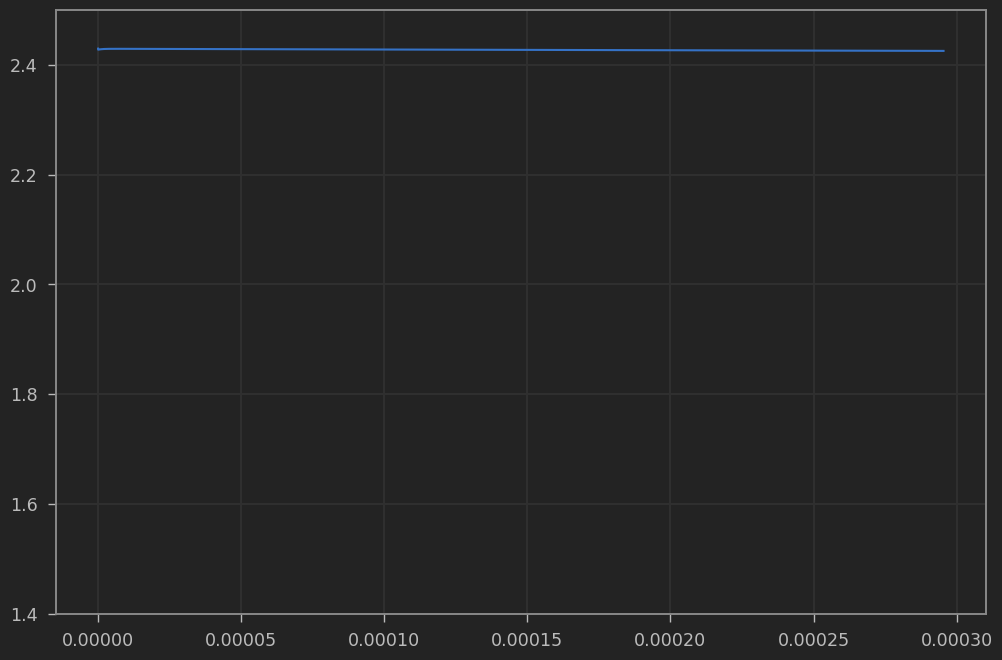

In [3]:
voltage = sim_hunt_3_current.solution['Terminal voltage [V]'].entries
plt.plot(abs(current)*sim_hunt_3_current.solution.t/3600,voltage)
#plt.plot(voltage312)
plt.ylim([1.4,2.5])
plt.grid(True)
notify

In [5]:
indices = np.where(voltage <= 2.4)
loc = -1#indices[0][0]
# extract initial conditon
S8_initial = sim_hunt_3_current.solution['S8 [g]'].entries[loc]
S8p_initial = sim_hunt_3_current.solution['S8p [g]'].entries[loc]
S4_initial = sim_hunt_3_current.solution['S4 [g]'].entries[loc]
S2_initial = sim_hunt_3_current.solution['S2 [g]'].entries[loc]
S_initial = sim_hunt_3_current.solution['S [g]'].entries[loc]
Sp_initial = sim_hunt_3_current.solution["Precipitated Sulfur [g]"].entries[loc]
V_initial = sim_hunt_3_current.solution['Terminal voltage [V]'].entries[loc]

In [99]:

# set new total activate material mass to give Hunt's 0.211 Ah cell capacity
m_s_hunt = .168

m_s_M = S8_initial + S8p_initial + S4_initial + S2_initial + S_initial + Sp_initial

S8_initial_frac_M  = S8_initial/m_s_M
S8p_initial_frac_M  = S8p_initial/m_s_M
S4_initial_frac_M  = S4_initial/m_s_M
S2_initial_frac_M  = S2_initial/m_s_M
S1_initial_frac_M  = S_initial/m_s_M
Sp_initial_frac_M  = Sp_initial/m_s_M

S8_initial_hunt = S8_initial_frac_M*m_s_hunt
S8p_initial_hunt = S8p_initial_frac_M*m_s_hunt
S4_initial_hunt = S4_initial_frac_M*m_s_hunt
S2_initial_hunt = S2_initial_frac_M*m_s_hunt
S1_initial_hunt = S1_initial_frac_M*m_s_hunt
Sp_initial_hunt = Sp_initial_frac_M*m_s_hunt
V_initial_hunt = 2.4

# these are global variables to avoid needing to input them 
# we are not fitting initial conditions yet
discharge_initial_data = [V_initial_hunt, 
        S8_initial_hunt,
        #S6_initial_hunt,
        S4_initial_hunt, 
        S2_initial_hunt, 
        S1_initial_hunt, 
        Sp_initial_hunt,
        S8p_initial_hunt]
discharge_initial_data

[2.4,
 0.15260238390453862,
 0.00022566804883694924,
 0.00016049396099520333,
 8.228643608556149e-11,
 1.5146162844575737e-07,
 0.015011302541714365]

In [161]:
factor = 12
'''
discharge_initial_data = [2.4,
 0.0753510818796232*10*factor,
 6.195256039306369e-05*factor,
 0.0027764130355405745*factor,
 1.5719673981517661e-06*factor,
 2.3575377810909363e-08*factor,
 0.005808956981667215*0.001*factor]
'''
model = pybamm.lithium_sulfur.MarinescuEtAl2016_3_current_S82minus()
current = 2*0.0211
hours = 5
time_in_seconds = 8000#14000#hours*3600
# (similar) parameters should be the same as in Marinescu et al. (2018)
# However, the  initial condition from charge appears to be the result of a discharge
params = model.default_parameter_values
params.update(
    {
        "Current function [A]": current,
        "Initial Condition for Terminal Voltage [V]": 2.4,#discharge_initial_data[0],
        "Initial Condition for S8 ion [g]": discharge_initial_data[1]*factor,#*2 ,
        "Initial Condition for S8p [g]": discharge_initial_data[-1]*factor ,
        #"Initial Condition for S6 ion [g]": discharge_initial_data[2],
        "Initial Condition for S4 ion [g]": discharge_initial_data[2] *factor,
        "Initial Condition for S2 ion [g]": discharge_initial_data[3]* factor,
        "Initial Condition for S ion [g]": discharge_initial_data[4] * factor,
        "Initial Condition for Precipitated Sulfur [g]": discharge_initial_data[5]* factor,
        #"Precipitation rate [s-1]": 50,
        #"Shuttle rate coefficient during discharge [s-1]": 0.0002,
        "Upper voltage cut-off [V]": 2.8,
        "Lower voltage cut-off [V]": 2.0,
        "Standard Potential L [V]": 1.95,#2.01,#1.9,#2.15
        "Standard Potential M [V]": 2.35,
        "Standard Potential H [V]": 2.38,
        #"Ambient Temperature [K]" : 302
        #"S saturation mass [g]": 1e-5,
        #"Electrolyte volume per cell [L]": 0.0114*.25
    }
)
params.process_model(model)
sim_hunt_3_current = pybamm.Simulation(
    model,
    parameter_values=params,
    solver=pybamm.CasadiSolver(
        atol=1e-6, 
        rtol=1e-3, 
        extra_options_setup={"max_step_size": 0.1}, 
        max_step_decrease_count = 15,
        #root_method = 'lm',
        #root_tol = 1e-7, 
        #dt_max = 1e-7
    ),
)
sim_hunt_3_current.solve(np.linspace(0, time_in_seconds, 10000))

psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
psetup failed: .../c

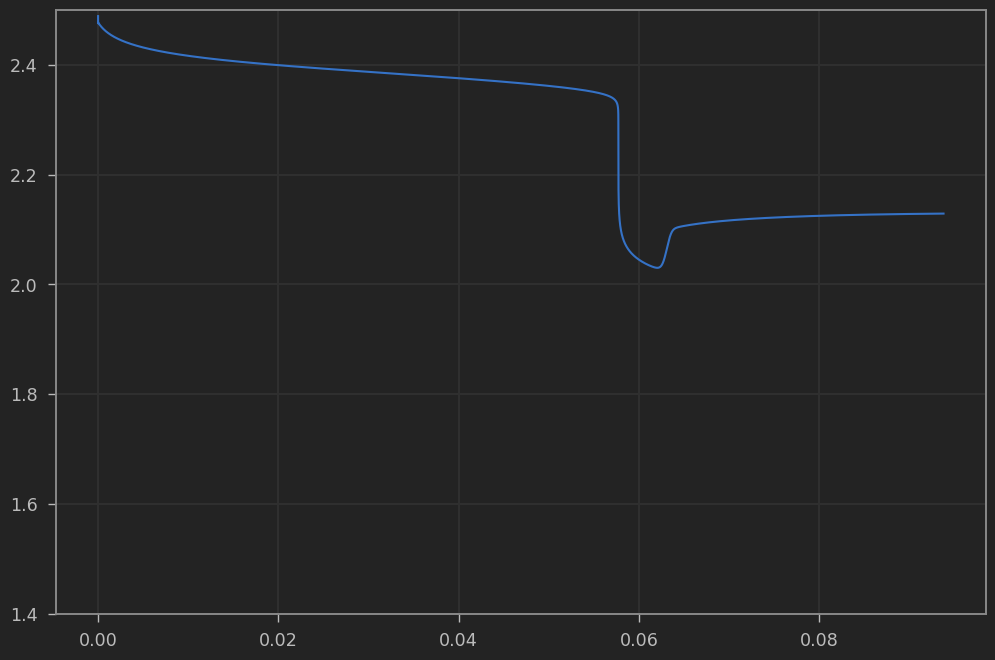

In [162]:
voltage = sim_hunt_3_current.solution['Terminal voltage [V]'].entries
plt.plot(abs(current)*sim_hunt_3_current.solution.t/3600,voltage)
#plt.plot(voltage312)
plt.ylim([1.4,2.5])
#plt.xlim([0,0.211])
plt.grid(True)
notify

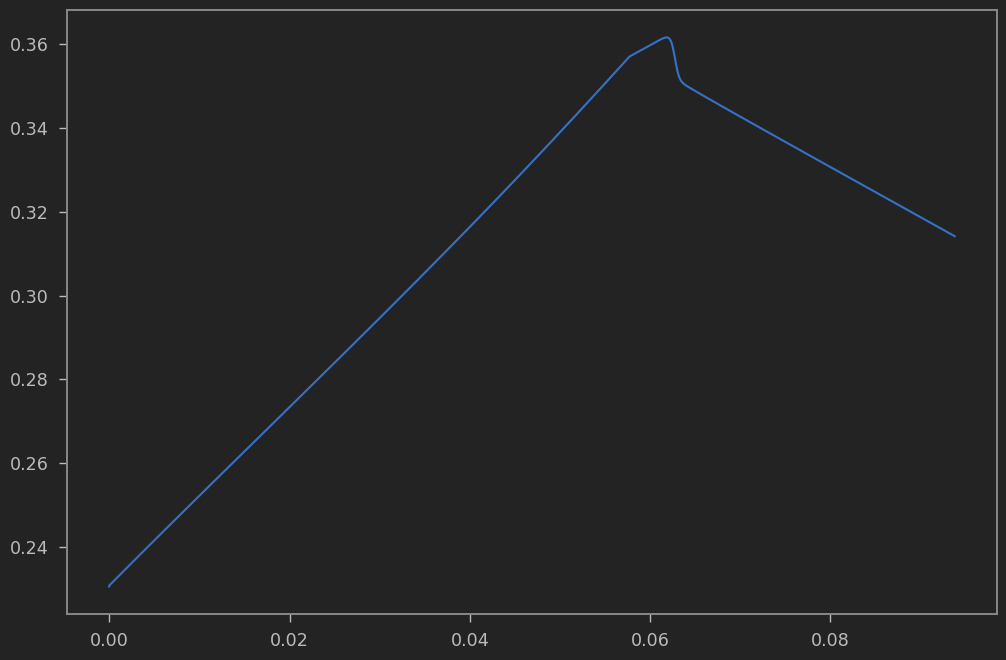

In [157]:
S8 = sim_hunt_3_current.solution['S8 [g]'].entries
S4 = sim_hunt_3_current.solution['S4 [g]'].entries
S2 = sim_hunt_3_current.solution['S2 [g]'].entries
S1 = sim_hunt_3_current.solution['S [g]'].entries
Li = S1 + 0.5*S2 + 0.25*S4 + (1/8)*S8
plt.plot(abs(current)*sim_hunt_3_current.solution.t/3600,Li)
#plt.xlim([0,0.211])

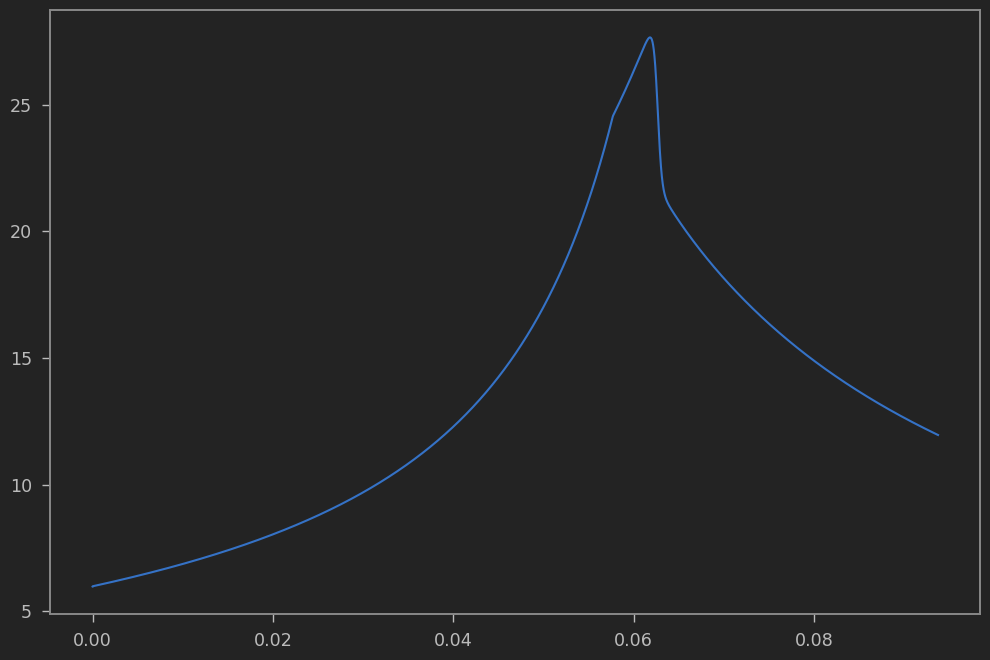

In [158]:
plt.plot(abs(current)*sim_hunt_3_current.solution.t/3600,1/(max(Li)*1.1 - Li))

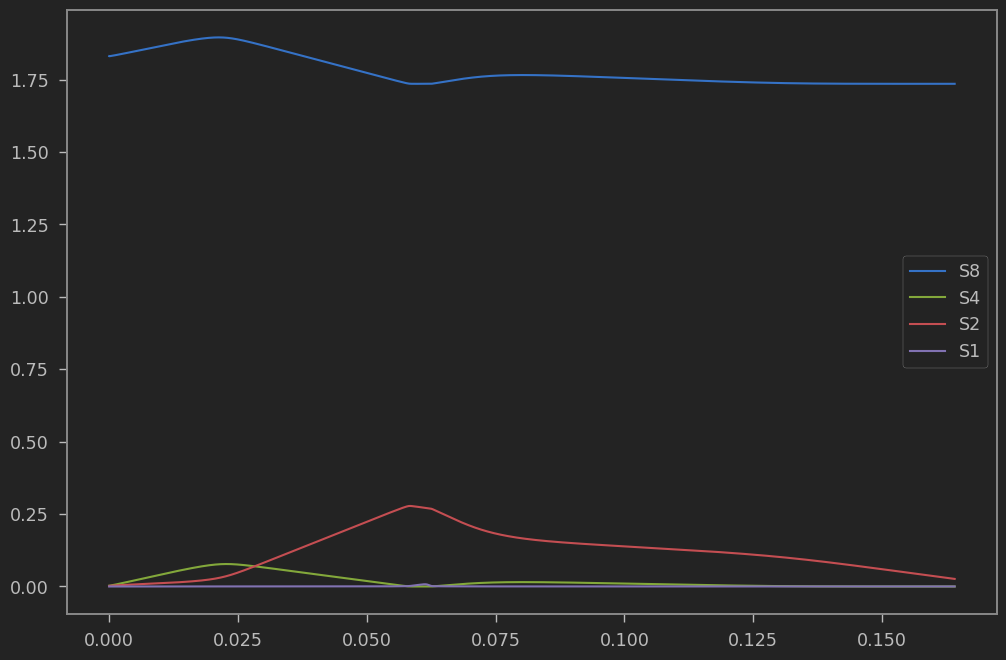

In [140]:
capacity =abs(current)*sim_hunt_3_current.solution.t/3600
plt.plot(capacity,S8)
plt.plot(capacity,S4)
plt.plot(capacity,S2)
plt.plot(capacity,S1)
plt.legend(['S8','S4','S2','S1'])

In [51]:
30*0.0211

0.633